# FATES MRV IFM sites

#### Libraries

In [1]:
import numpy as np
import xarray as xr
import csv
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm

from scipy.optimize import curve_fit
from scipy.stats import linregress

## Read in the data from Mexico's National Forest and Soils  Inventory (INFyS)
- Note we are using 2015-2020 data
- We only read in plots from the state of Puebla

In [2]:
df_full  = pd.read_csv('/Users/JFNeedham/Desktop/FATES-MRV/Mexico_forest_inventory_data-FATES-MRV/INFyS_2015_2020_Puebla_RYw2D2Y.csv', low_memory=False)

In [3]:
df_full.head(3)

,UPMID,IdConglomerado,ArboladoID_C3,Anio_C3,Cve_Estado_C3,Estado_C3,CVEECON1_C3,CVEECON2_C3,CVEECON3_C3,CVEECON4_C3,...,DiametroBasalSub_validacion_C3,Edad_C3,NumeroAnillos25_C3,LongitudAnillos10_C3,GrosorCorteza_C3,es_para_estimacion_Volumen_C3,VolumenVRTA_m3_C3,es_para_estimacion_ByC,biomasa_kg_C3,carbono_kg_C3
0,35383.0,69105.0,397575.0,2016.0,21.0,Puebla,14.0,14.4,14.4.1,14.4.1.1,...,999991.0,999991.0,999991.0,999991.0,999991.0,1.0,0.019231,1.0,15.266167,7.022437
1,35383.0,69105.0,397590.0,2016.0,21.0,Puebla,14.0,14.4,14.4.1,14.4.1.1,...,999991.0,999991.0,999991.0,999991.0,999991.0,1.0,0.018887,1.0,15.947983,7.336072
2,35383.0,69105.0,397595.0,2016.0,21.0,Puebla,14.0,14.4,14.4.1,14.4.1.1,...,999991.0,999991.0,999991.0,999991.0,999991.0,0.0,999991.000000,1.0,1.926283,0.861048


#### Keep only relevant columns

In [4]:
df_sub = df_full[['IdConglomerado', 'Genero_APG_C3', 'Especie_APG_C3', 'DiametroNormal_C3', 'AlturaTotal_C3', 'AreaCopa_C3', 'biomasa_kg_C3', 
                  'X_C3', 'Y_C3', 'Forma_Biologica_Cat_C3', 'DESCRIP_S7_C3']]

# translate column names
df_sub.columns =  ['Plot', 'Genus', 'Species', 'dbh', 'height', 'CA', 'agb', 'lat', 'lon', 'lifeform', 'site_descriptor']

# make a latin binomial column and get rid of Nas (prevent filtering later)
df_sub.loc[:,'Latin'] = df_sub['Genus'].str.cat(df_sub['Species'], sep=' ')

# set NaNs to 'unknown'
df_sub['Latin'].fillna('unknown', inplace=True)

/var/folders/_z/c4vb166j43x4kskctr4djwmr0000gp/T/ipykernel_89091/1301220627.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.loc[:,'Latin'] = df_sub['Genus'].str.cat(df_sub['Species'], sep=' ')
/var/folders/_z/c4vb166j43x4kskctr4djwmr0000gp/T/ipykernel_89091/1301220627.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['Latin'].fillna('unknown', inplace=True)


In [5]:
df_sub.head(3)

,Plot,Genus,Species,dbh,height,CA,agb,lat,lon,lifeform,site_descriptor,Latin
0,69105.0,Mimosa,benthamii,8.7,5.2,5.1051,15.266167,-98.557139,17.980417,Arbol,VEGETACIÓN SECUNDARIA ARBUSTIVA DE BOSQUE DE E...,Mimosa benthamii
1,69105.0,Mimosa,benthamii,8.9,4.9,7.0686,15.947983,-98.557139,17.980417,Arbol,VEGETACIÓN SECUNDARIA ARBUSTIVA DE BOSQUE DE E...,Mimosa benthamii
2,69105.0,ZZ Genero Desconocido,NaN,21.0,0.2,999993.0000,1.926283,-98.557139,17.980417,Indeterminada,VEGETACIÓN SECUNDARIA ARBUSTIVA DE BOSQUE DE E...,unknown


## Size distribution 

#### Filter by oak pine forests

In [6]:
df_sub = df_sub[df_sub['dbh'] < 1000]  # remove outliers
df_sub = df_sub[df_sub['lifeform'] == 'Arbol'] # only keep trees

# subset by forest types
#print(df_sub['site_descriptor'].unique())

oak_pine = ['BOSQUE DE PINO-ENCINO', 'BOSQUE DE ENCINO-PINO', 'BOSQUE DE PINO', 'BOSQUE DE ENCINO'] # define forest types to keep
oak_pine_df = df_sub[df_sub['site_descriptor'].str.contains('|'.join(oak_pine))]

oak_pine_df.head(10)
#print(oak_pine_df['site_descriptor'].unique())  # still some shruby plants

oak_pine_df = oak_pine_df[~oak_pine_df['site_descriptor'].str.contains('ARBUSTIVA')] # remove shrubs
#print(oak_pine_df['site_descriptor'].unique()) 

# just oaks
oak_df = oak_pine_df[oak_pine_df['Genus'].str.contains('Quercus')]
print(oak_df.head(3))

# just  pines 
pine_df = oak_pine_df[oak_pine_df['Genus'].str.contains('Pinus')]

        Plot    Genus      Species   dbh  height         CA         agb  \
93   67278.0  Quercus          NaN  10.6     5.1  12.880560   29.149596   
314  67012.0  Quercus          NaN   8.1     4.0   1.327326   13.880127   
467  65843.0  Quercus  scytophylla  22.1     5.2  10.461528  199.272452   

           lat        lon lifeform        site_descriptor                Latin  
93  -98.360028  18.292361    Arbol       BOSQUE DE ENCINO              unknown  
314 -96.938306  18.296500    Arbol         BOSQUE DE PINO              unknown  
467 -97.168611  18.485111    Arbol  BOSQUE DE PINO-ENCINO  Quercus scytophylla  


Text(0.5, 0.01, 'DBH (cm)')

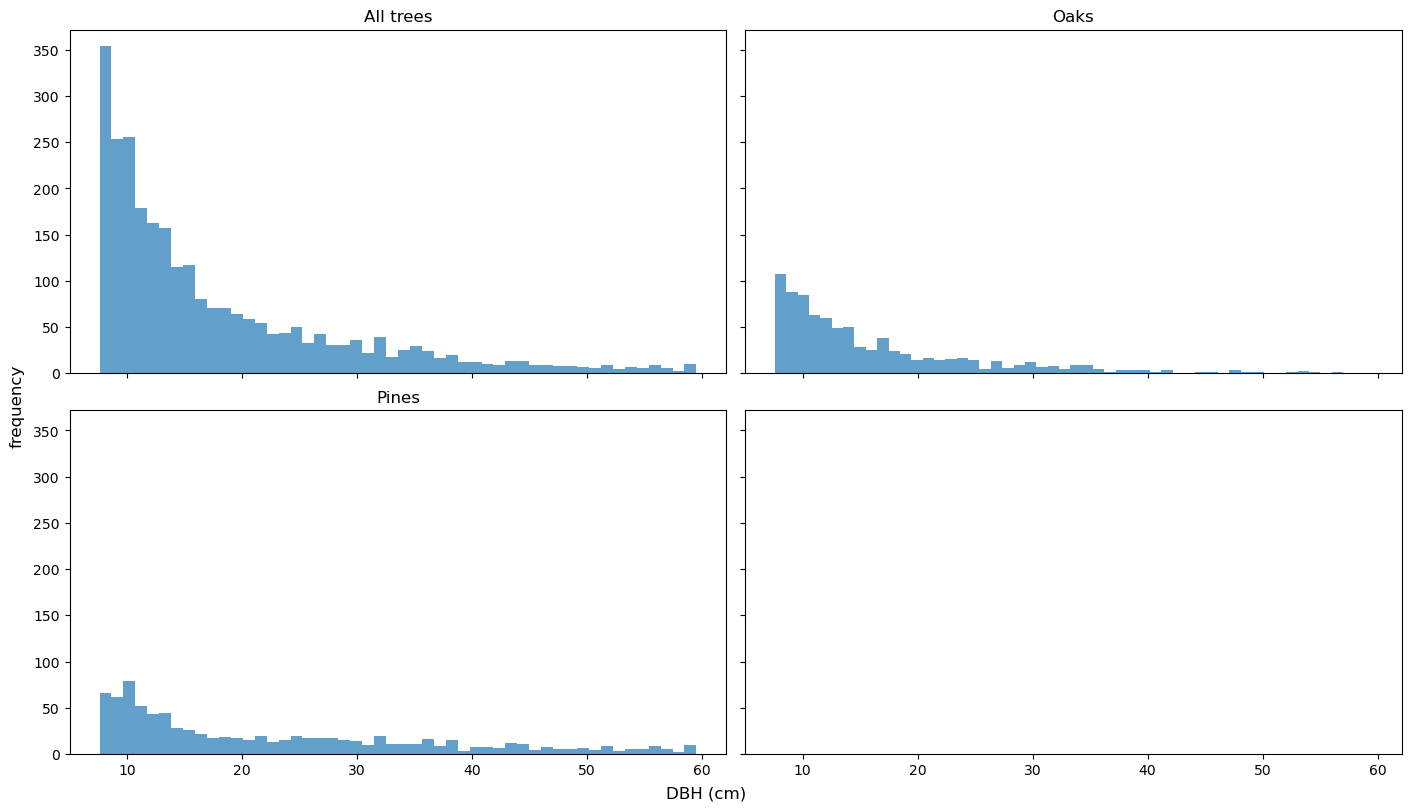

In [7]:
fig, ((fax0,fax1),(fax2,fax3)) = plt.subplots(nrows=2, ncols=2, figsize=(14,8), sharey=True, sharex=True, constrained_layout=True)

fax0.hist(oak_pine_df['dbh'], bins = 50, alpha=0.7)
fax0.set_title('All trees')

fax1.hist(oak_df['dbh'], bins = 50, alpha=0.7)
fax1.set_title('Oaks')

fax2.hist(pine_df['dbh'], bins = 50, alpha=0.7)
fax2.set_title('Pines')

fig.supylabel('frequency')
fig.supxlabel('DBH (cm)')

#### Save for FATES comparison

In [8]:
# divide into size bins
sizebins = [7.5, 15, 20, 30, 40, 50, 60, 70]

# Nb divide by X to get it per ha

# how many plots in the whole dataset
numplots = len(oak_pine_df['Plot'].unique())
totalarea = (400 * numplots)/10000 # now in ha


binned = pd.cut(oak_pine_df['dbh'], bins=sizebins)
bin_counts_all = binned.value_counts()
all = bin_counts_all.values/totalarea

binned = pd.cut(oak_df['dbh'], bins=sizebins)
bin_counts_oak = binned.value_counts()
oak = bin_counts_oak.values/totalarea

binned = pd.cut(pine_df['dbh'], bins=sizebins)
bin_counts_pine = binned.value_counts()
pine = bin_counts_pine.values/totalarea


sizedists = pd.DataFrame({'lower_bin_edge':sizebins[:-1], 'All':all, 'Oak':oak, 'Pine':pine})

sizedists.to_csv('Size_distributions_Puebla.csv', index=False)

## Allometries

#### Evergreen PFT - pines and firs known to be in the San Rafael site

In [9]:
species = ['Pinus teocote','Pinus montezumae','Pinus leiophylla','Pinus hartwegii','Abies religiosa', 'Pinus ayacahuite']
evergreen = df_sub[df_sub['Latin'].str.contains('|'.join(species))]
print(len(evergreen))
evergreen.head(5)

477


,Plot,Genus,Species,dbh,height,CA,agb,lat,lon,lifeform,site_descriptor,Latin
4426,63365.0,Pinus,leiophylla,39.3,13.1,52.166268,758.795199,-98.628444,18.932361,Arbol,BOSQUE DE ENCINO-PINO,Pinus leiophylla
4970,62376.0,Pinus,hartwegii,27.3,10.2,15.550920,234.177315,-98.623917,19.113472,Arbol,BOSQUE DE PINO,Pinus hartwegii
5096,62901.0,Abies,religiosa,24.5,20.1,12.566400,252.100646,-97.341306,18.988722,Arbol,BOSQUE DE PINO,Abies religiosa
5097,62901.0,Abies,religiosa,35.1,27.2,33.693660,622.237774,-97.341306,18.988722,Arbol,BOSQUE DE PINO,Abies religiosa
5098,62901.0,Abies,religiosa,20.8,8.2,29.703828,167.067798,-97.341306,18.988722,Arbol,BOSQUE DE PINO,Abies religiosa


#### Oaks 

In [10]:
oaks = df_sub[df_sub['Genus'].str.contains('Quercus')]
print(len(oaks))
oaks.head(5)

1609


,Plot,Genus,Species,dbh,height,CA,agb,lat,lon,lifeform,site_descriptor,Latin
93,67278.0,Quercus,NaN,10.6,5.1,12.880560,29.149596,-98.360028,18.292361,Arbol,BOSQUE DE ENCINO,unknown
151,66979.0,Quercus,glaucoides,24.4,6.0,16.619064,182.869626,-98.500528,18.340972,Arbol,VEGETACIÓN SECUNDARIA ARBUSTIVA DE BOSQUE DE E...,Quercus glaucoides
152,66979.0,Quercus,NaN,8.0,6.0,1.649340,14.877727,-98.500528,18.340972,Arbol,VEGETACIÓN SECUNDARIA ARBUSTIVA DE BOSQUE DE E...,unknown
153,66979.0,Quercus,NaN,22.3,7.9,9.896040,172.424966,-98.500528,18.340972,Arbol,VEGETACIÓN SECUNDARIA ARBUSTIVA DE BOSQUE DE E...,unknown
156,66979.0,Quercus,glaucoides,29.7,4.2,15.550920,333.103946,-98.500528,18.340972,Arbol,VEGETACIÓN SECUNDARIA ARBUSTIVA DE BOSQUE DE E...,Quercus glaucoides


### Functions

In [11]:
def d2hmc (d, p1, p2, p3) :
    h = (p1 * d**p2) / (p3 + d**p2)
    return h

initial_guess_h = [58.0, 0.73, 21.8]


In [12]:
def d2ca (d, p1, p2) :
    ca = p1 * d ** p2
    return ca

initial_guess_ca = [0.07, 1.3]

In [13]:
def d2bagw (d, p1, p2) :
    bagw = (p1 * d**p2) 
    return bagw

# Note in FATES this is divided by 2 to get carbon. But measurements are in biomass? Is this correct?

### Height

In [14]:
oak_h = oaks.dropna(subset=['height', 'dbh'])
# remove outliers
oak_h = oak_h[oak_h['dbh'] < 1000]
oak_h = oak_h[oak_h['height'] < 1000]
dbh_oak_h = np.arange(1,oak_h['dbh'].max(),1)

height_ps_oak, height_cov_oak = curve_fit(f=d2hmc, xdata=np.array(oak_h['dbh']), ydata=np.array(oak_h['height']),
                                           p0=initial_guess_h)
oak_curve_h = [d2hmc(d, height_ps_oak[0], height_ps_oak[1], height_ps_oak[2])  for  d  in dbh_oak_h]
print(height_ps_oak)

[6.45389888e+06 5.42743374e-01 3.80722752e+06]


In [15]:
evg_h = evergreen.dropna(subset=['height', 'dbh'])
# remove outliers
evg_h = evg_h[evg_h['dbh'] < 1000]
dbh_evg_h = np.arange(1,evg_h['dbh'].max(),1)

height_ps_evg, height_cov_evg = curve_fit(f=d2hmc, xdata=np.array(evg_h['dbh']), ydata=np.array(evg_h['height']),
                                           p0=initial_guess_h)
evg_curve_h = [d2hmc(d, height_ps_evg[0], height_ps_evg[1], height_ps_evg[2])  for  d  in dbh_evg_h]
print(height_ps_evg)


[47.02238834  1.01099235 61.65702984]


Text(0.5, 0, 'DBH (cm)')

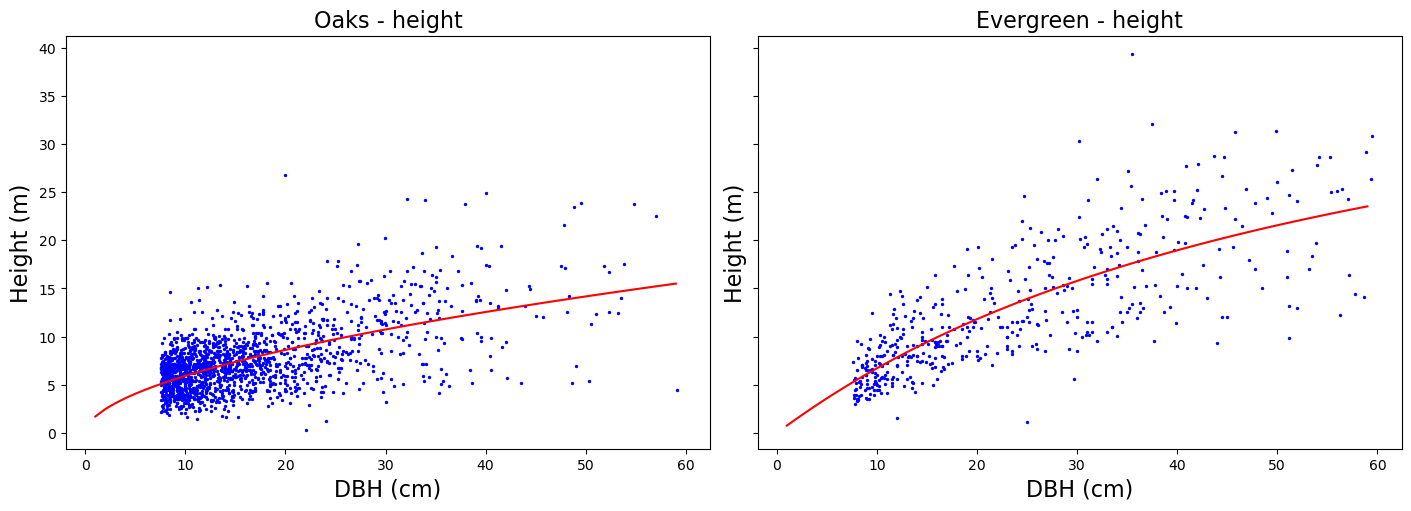

In [16]:
fig, ((fax0,fax1)) = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True, sharex=True, constrained_layout=True)

fax0.scatter(oak_h.dbh, oak_h.height, c='blue', s=2)
fax0.plot(dbh_oak_h, oak_curve_h, color='red')
fax0.set_title('Oaks - height', fontsize=16)
fax0.set_ylabel('Height (m)', fontsize=16)
fax0.set_xlabel('DBH (cm)', fontsize=16)

fax1.scatter(evg_h.dbh, evg_h.height, c='blue', s=2)
fax1.plot(dbh_evg_h, evg_curve_h, color='red')
fax1.set_title('Evergreen - height', fontsize=16)
fax1.set_ylabel('Height (m)', fontsize=16)
fax1.set_xlabel('DBH (cm)', fontsize=16)



### Crown area 

In [17]:
oak_ca = oaks.dropna(subset=['CA','dbh'])
# remove outliers
oak_ca = oak_ca[oak_ca['dbh'] < 1000]
oak_ca = oak_ca[oak_ca['CA'] < 1000]
dbh_oak_ca = np.arange(1,oak_ca['dbh'].max(),1)

ca_ps_oak, ca_cov_oak = curve_fit(f=d2ca, xdata=np.array(oak_ca['dbh']), ydata=np.array(oak_ca['CA']), p0=initial_guess_ca)

oak_curve_ca = [d2ca(d, ca_ps_oak[0], ca_ps_oak[1])  for  d  in dbh_oak_ca]

print(ca_ps_oak)

[0.61001172 1.1459558 ]


In [18]:
evg_ca = evergreen.dropna(subset=['CA','dbh'])
# remove outliers
evg_ca = evg_ca[evg_ca['dbh'] < 1000]
evg_ca = evg_ca[evg_ca['CA'] < 1000]
dbh_evg_ca = np.arange(1,evg_ca['dbh'].max(),1)

ca_ps_evg, ca_cov_evg = curve_fit(f=d2ca, xdata=np.array(evg_ca['dbh']), ydata=np.array(evg_ca['CA']), p0=initial_guess_ca)

evg_curve_ca = [d2ca(d, ca_ps_evg[0], ca_ps_evg[1])  for  d  in dbh_evg_ca]

print(ca_ps_evg)

[0.41284662 1.24382974]


Text(0.5, 0, 'DBH (cm)')

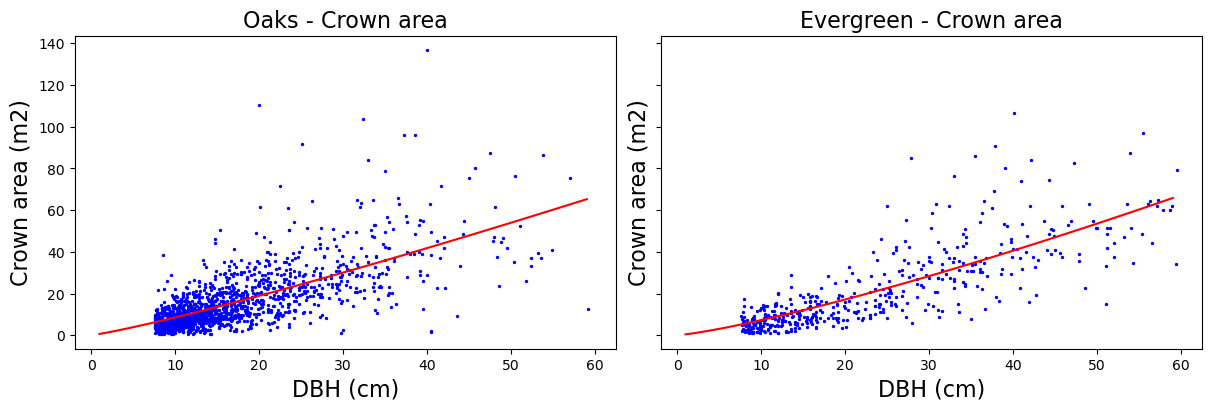

In [19]:
fig, ((fax0,fax1)) = plt.subplots(nrows=1, ncols=2, 
                                  figsize=(12,4), sharey=True, sharex=True, constrained_layout=True)

fax0.scatter(oak_ca.dbh, oak_ca.CA, c='blue', s=2)
fax0.plot(dbh_oak_ca, oak_curve_ca, color='red')
fax0.set_title('Oaks - Crown area', fontsize=16)
fax0.set_ylabel('Crown area (m2)', fontsize=16)
fax0.set_xlabel('DBH (cm)', fontsize=16)

fax1.scatter(evg_ca.dbh, evg_ca.CA, c='blue', s=2)
fax1.plot(dbh_evg_ca, evg_curve_ca, color='red')
fax1.set_title('Evergreen - Crown area', fontsize=16)
fax1.set_ylabel('Crown area (m2)', fontsize=16)
fax1.set_xlabel('DBH (cm)', fontsize=16)




### Biomass

Use power function with parameters from Návar 2009 Forest Ecology and Management, a = 0.1229, b = 2.3964 for Pine and a = 0.0890, b = 2.5226 for Oaks. 

In [20]:
oak_agb = oaks.dropna(subset=['agb','dbh'])
# remove outliers
oak_agb = oak_agb[oak_agb['dbh'] < 1000]
oak_agb = oak_agb[oak_agb['agb'] < 8000]
dbh_oak_agb = np.arange(1,oak_agb['dbh'].max(),1)

oak_curve_agb = [d2bagw(d, 0.089, 2.5226)  for  d  in dbh_oak_agb]


evg_agb = evergreen.dropna(subset=['agb','dbh'])
# remove outliers
evg_agb = evg_agb[evg_agb['dbh'] < 1000]
evg_agb = evg_agb[evg_agb['agb'] < 8000]
dbh_evg_agb = np.arange(1,evg_agb['dbh'].max(),1)

evg_curve_agb = [d2bagw(d, 0.1229, 2.3964)  for  d  in dbh_evg_agb]




Text(0.5, 0, 'DBH (cm)')

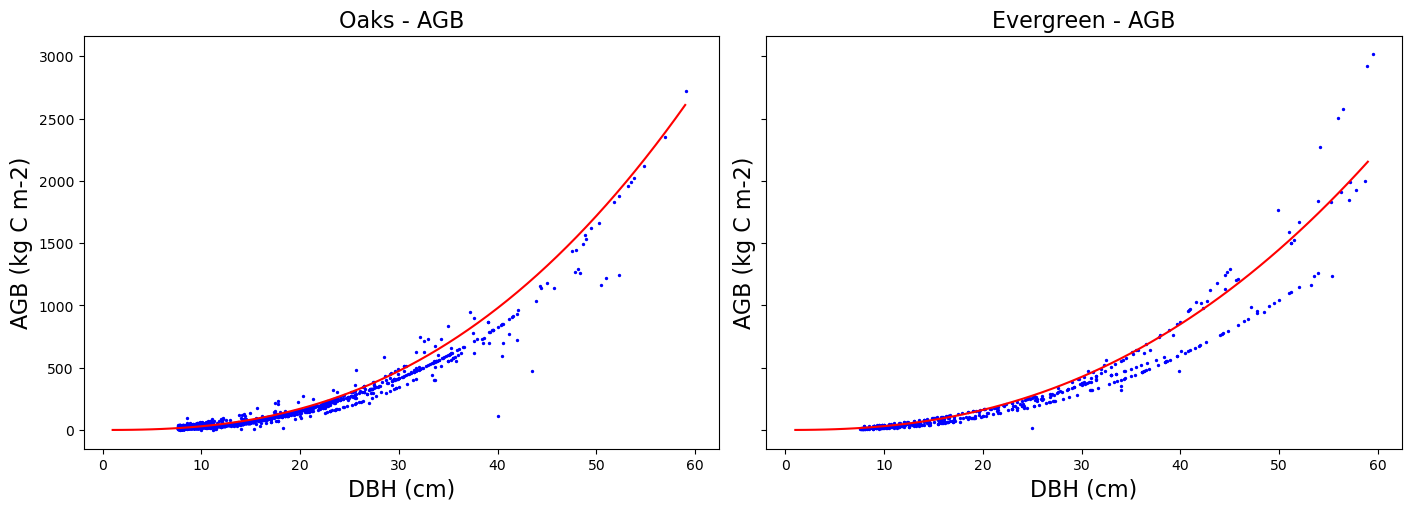

In [21]:
fig, ((fax0,fax1)) = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True, sharex=True, constrained_layout=True)


fax0.scatter(oak_agb.dbh, oak_agb.agb, c='blue', s=2)
fax0.plot(dbh_oak_agb, oak_curve_agb, color='red')
fax0.set_title('Oaks - AGB', fontsize=16)
fax0.set_ylabel('AGB (kg C m-2)', fontsize=16)
fax0.set_xlabel('DBH (cm)', fontsize=16)

fax1.scatter(evg_agb.dbh, evg_agb.agb, c='blue', s=2)
fax1.plot(dbh_evg_agb, evg_curve_agb, color='red')
fax1.set_title('Evergreen - AGB', fontsize=16)
fax1.set_ylabel('AGB (kg C m-2)', fontsize=16)
fax1.set_xlabel('DBH (cm)', fontsize=16)



### Leaf biomass 

In [22]:
def d2bl (d, p1, p2) : 
    blmax = (p1 * d **  p2) / 2.0
    return blmax

### LAI 

In [23]:
def decay_coeff_kn ( vcmax25top ) :
    kn = np.exp(0.00963 * vcmax25top  - 2.43)
    return kn

In [24]:
def tree_lai ( leaf_c, c_area, vcmax25top, slatop, slamax) :
    
    g_per_kg = 1000.0
    slat = g_per_kg * slatop
    leafc_per_unitarea = leaf_c / c_area
    canopy_lai_above = 0
        
    kn = decay_coeff_kn(vcmax25top)
    sla_max = g_per_kg * slamax
    leafc_slamax = (slat - sla_max * np.exp(-1.0 * kn * canopy_lai_above)) / (
        -1.0 * kn * slat * sla_max) 
    
    if (leafc_per_unitarea <= leafc_slamax) : 
        tree_lai = (np.log (np.exp(-1 * kn * canopy_lai_above) - kn * slat  * leafc_per_unitarea) + 
                    (kn * canopy_lai_above)) / (-1 * kn)
    else : 
        tree_lai = ((np.log (np.exp(1 * kn * canopy_lai_above) - kn * slat * leafc_slamax) + 
                     (kn * canopy_lai_above)) / (-1 * kn))  +  (leafc_per_unitarea -
                                                                leafc_slamax) * sla_max
        
    return tree_lai

In [25]:
vcmax25top = [61,62]
nitr_stoich  = [0.033, 0.029]
slatop = [0.009, 0.005]
slamax= [0.0954, 0.0954]
lnc_top =  [a / b for a,  b  in  zip(nitr_stoich,  slatop)]
umolC_to_kgC = 12.0e-9
g_per_kg = 1000.0

ca_p1 = [ca_ps_oak[0], ca_ps_evg[0]]
ca_p2 =  [ca_ps_oak[1], ca_ps_evg[1]]

d2bl1 = [0.06, 0.05]
d2bl2 = [a * 1.2 for a in ca_p2]
print(d2bl2)

diffs = [a - b for a,b in zip(ca_p2, d2bl2)]
print(diffs)
print(ca_p2)

pftnames = ['Oaks', 'Pines']

[1.3751469641781888, 1.4925956877398388]
[-0.2291911606963648, -0.24876594795663975]
[1.145955803481824, 1.243829739783199]


''

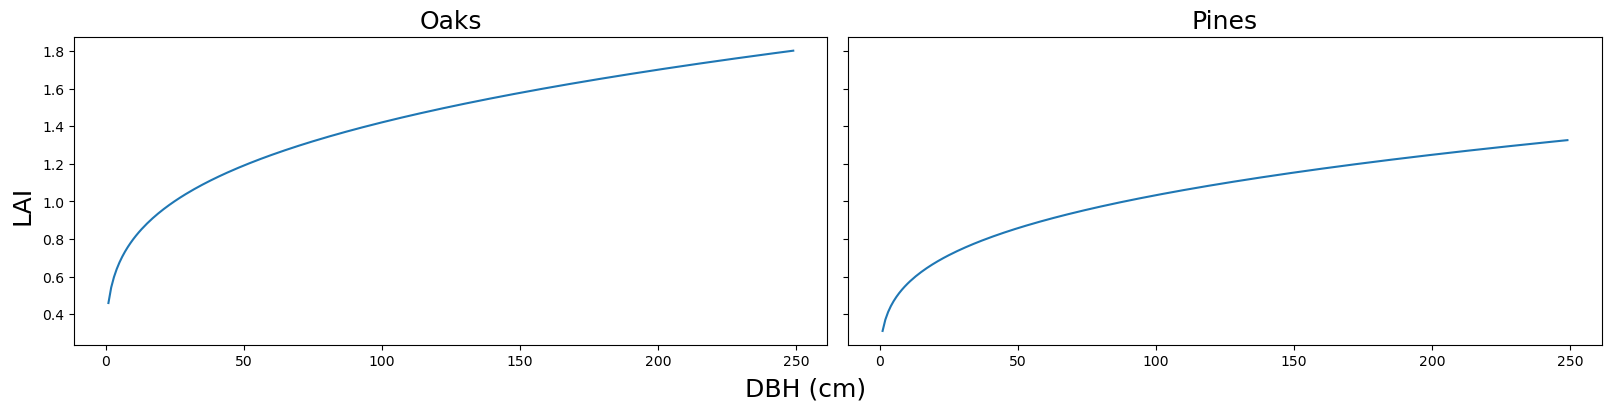

In [26]:
fig2, axs = plt.subplots(nrows=1,ncols=2,
                        figsize=(16,4), constrained_layout=True, sharex=True, sharey=True)

axs = axs.flatten()

# for each tree PFT calculate total vai
for pf in range(0, 2) : 
    
    dbh = np.arange(1,250,1)
    
    # calculate leaf carbon
    bleaf_curve = [d2bl(d, d2bl1[pf], d2bl2[pf])  for  d  in dbh]
    
    # calculate crown area
    ca_curve = [d2ca(d, ca_p1[pf],  ca_p2[pf])  for  d  in dbh]
    
    lai_curve = [tree_lai( leaf_c, c_area, vcmax25top[pf], slatop[pf], slamax[pf])
             for leaf_c, c_area in zip(bleaf_curve, ca_curve)]
    
    axs[pf].plot(dbh, lai_curve)
    axs[pf].set_title(pftnames[pf], fontsize=18)

fig2.supylabel('LAI', fontsize=18)
fig2.supxlabel('DBH (cm)', fontsize=18)  
;

Text(0.5, 0, 'DBH (cm)')

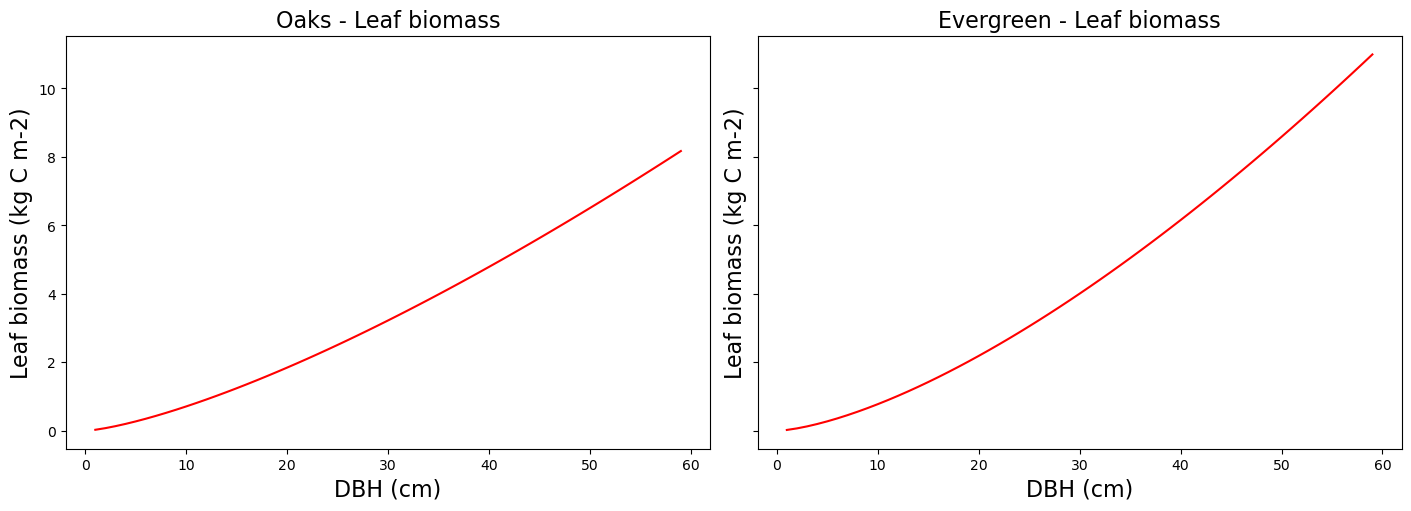

In [27]:
evg_curve_bl = [d2bl(d, d2bl1[1], d2bl2[1])  for  d  in dbh_evg_agb]

oak_curve_bl = [d2bl(d, d2bl1[0], d2bl2[0])  for  d  in dbh_oak_agb]

fig, ((fax0,fax1)) = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True, sharex=True, constrained_layout=True)


fax0.plot(dbh_oak_agb, oak_curve_bl, color='red')
fax0.set_title('Oaks - Leaf biomass', fontsize=16)
fax0.set_ylabel('Leaf biomass (kg C m-2)', fontsize=16)
fax0.set_xlabel('DBH (cm)', fontsize=16)

fax1.plot(dbh_evg_agb, evg_curve_bl, color='red')
fax1.set_title('Evergreen - Leaf biomass', fontsize=16)
fax1.set_ylabel('Leaf biomass (kg C m-2)', fontsize=16)
fax1.set_xlabel('DBH (cm)', fontsize=16)

